# Exercise 1: Compute the SVD of a Matrix & Verify the Reconstruction
This exercise focuses on the fundamental property of Singular Value Decomposition (SVD): factorizing a matrix $A$ into $U$, $\Sigma$, and $V^T$ and verifying that their product reconstructs the original matrix.

Original Matrix A shape: (10, 6)
U shape: (10, 10)
Sigma shape: (10, 6)
Vt shape: (6, 6)

Reconstruction Error (Frobenius Norm): 5.85e-15
Is A close to reconstruction? True

Singular Values: [4.53270928 3.73907164 2.72173241 1.89806806 1.59069575 1.43784506]


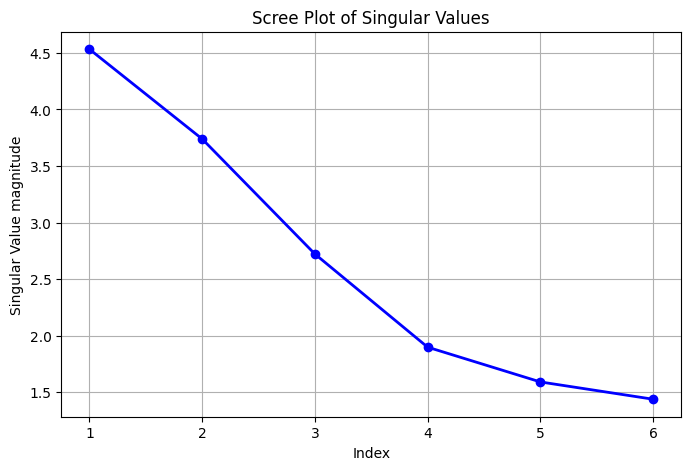

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Construct a non-square matrix A
np.random.seed(42)  # For reproducibility
m, n = 10, 6
A = np.random.randn(m, n)

print("Original Matrix A shape:", A.shape)

# 2. Compute its SVD
# full_matrices=True returns U as (m, m) and Vt as (n, n)
U, s, Vt = np.linalg.svd(A, full_matrices=True)

# Construct the Sigma matrix (rectangular diagonal matrix)
Sigma = np.zeros((m, n))
# Fill the diagonal with singular values
np.fill_diagonal(Sigma, s)

print("U shape:", U.shape)
print("Sigma shape:", Sigma.shape)
print("Vt shape:", Vt.shape)

# 3. Verify numerically that A ≈ U * Sigma * Vt
A_reconstructed = U @ Sigma @ Vt
reconstruction_error = np.linalg.norm(A - A_reconstructed, ord="fro")

print(f"\nReconstruction Error (Frobenius Norm): {reconstruction_error:.2e}")
print(f"Is A close to reconstruction? {np.allclose(A, A_reconstructed)}")

# 4. Print and plot the singular values
print("\nSingular Values:", s)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(s) + 1), s, "bo-", linewidth=2)
plt.title("Scree Plot of Singular Values")
plt.xlabel("Index")
plt.ylabel("Singular Value magnitude")
plt.grid(True)
plt.show()

Comments & Discussion:
- Descending Order: Singular values ($\sigma_i$) appear in descending order because the SVD algorithm sequentially captures the directions (principal components) of maximum variance in the data. The first singular value corresponds to the direction with the most "energy" or variance.

- Importance: Small singular values correspond to directions where the matrix (which can be viewed as a linear transformation) scales vectors by a small factor. In data analysis, these often represent noise or redundant information.

- Floating-point Arithmetic: You rarely see exact zeros in floating-point calculations due to machine precision. Instead, you get very small numbers (e.g., $10^{-16}$) which should be treated as effective zeros (numerical rank).

# Exercise 2: Best Rank-$k$ Approximation
This exercise demonstrates the Eckart-Young-Mirsky theorem, which states that the truncated SVD provides the optimal rank-$k$ approximation of a matrix in terms of the Frobenius norm.

k=1: Approximation Error = 5.4396
k=2: Approximation Error = 3.9507
k=3: Approximation Error = 2.8636
k=4: Approximation Error = 2.1442
k=5: Approximation Error = 1.4378
k=6: Approximation Error = 0.0000


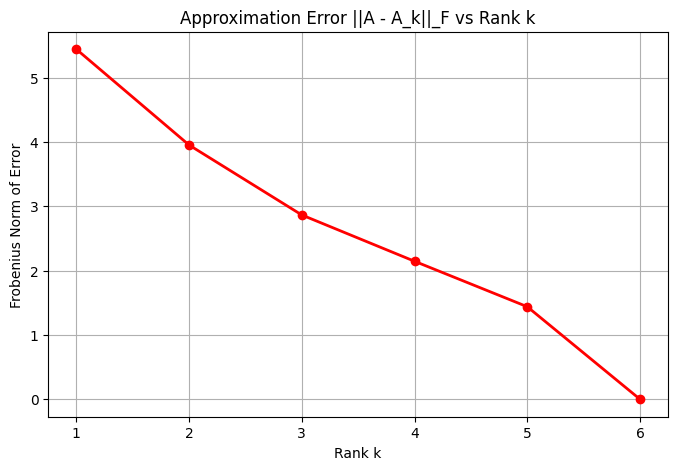

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Setup from previous exercise
np.random.seed(42)
A = np.random.randn(10, 6)
U, s, Vt = np.linalg.svd(A, full_matrices=True)


# 1. Implement a function for Rank-k approximation
def compute_rank_k_approximation(U, s, Vt, k):
    """
    Computes the rank-k approximation of a matrix given its SVD components.
    A_k = sum_{i=1}^k sigma_i * u_i * v_i^T
    """
    # Create the Sigma matrix for the first k singular values
    Sigma_k = np.zeros((U.shape[0], Vt.shape[0]))
    np.fill_diagonal(Sigma_k[:k, :k], s[:k])

    # We essentially zero out singular values after index k
    # Alternatively: A_k = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    A_k = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    return A_k


# 2. Compute approximation error E(k) for several values of k
m, n = A.shape
max_rank = min(m, n)
errors = []
k_values = range(1, max_rank + 1)

for k in k_values:
    A_k = compute_rank_k_approximation(U, s, Vt, k)
    error = np.linalg.norm(A - A_k, ord="fro")
    errors.append(error)
    print(f"k={k}: Approximation Error = {error:.4f}")

# 3. Plot the approximation error E(k) vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, "r-o", linewidth=2)
plt.title("Approximation Error ||A - A_k||_F vs Rank k")
plt.xlabel("Rank k")
plt.ylabel("Frobenius Norm of Error")
plt.xticks(k_values)
plt.grid(True)
plt.show()

**Why SVD gives the optimal approximation:** The singular values represent the magnitude of the matrix along orthogonal directions. By selecting the top $k$ singular values, we retain the maximum possible energy (variance) of the matrix allowed by a rank-$k$ constraint. Any other choice of rank-$k$ matrix would result in a larger residual error.

# Exercise 3: Image Compression with SVD
Here we apply SVD to a real image to see how dimensionality reduction affects visual quality.

Image shape: (512, 512)


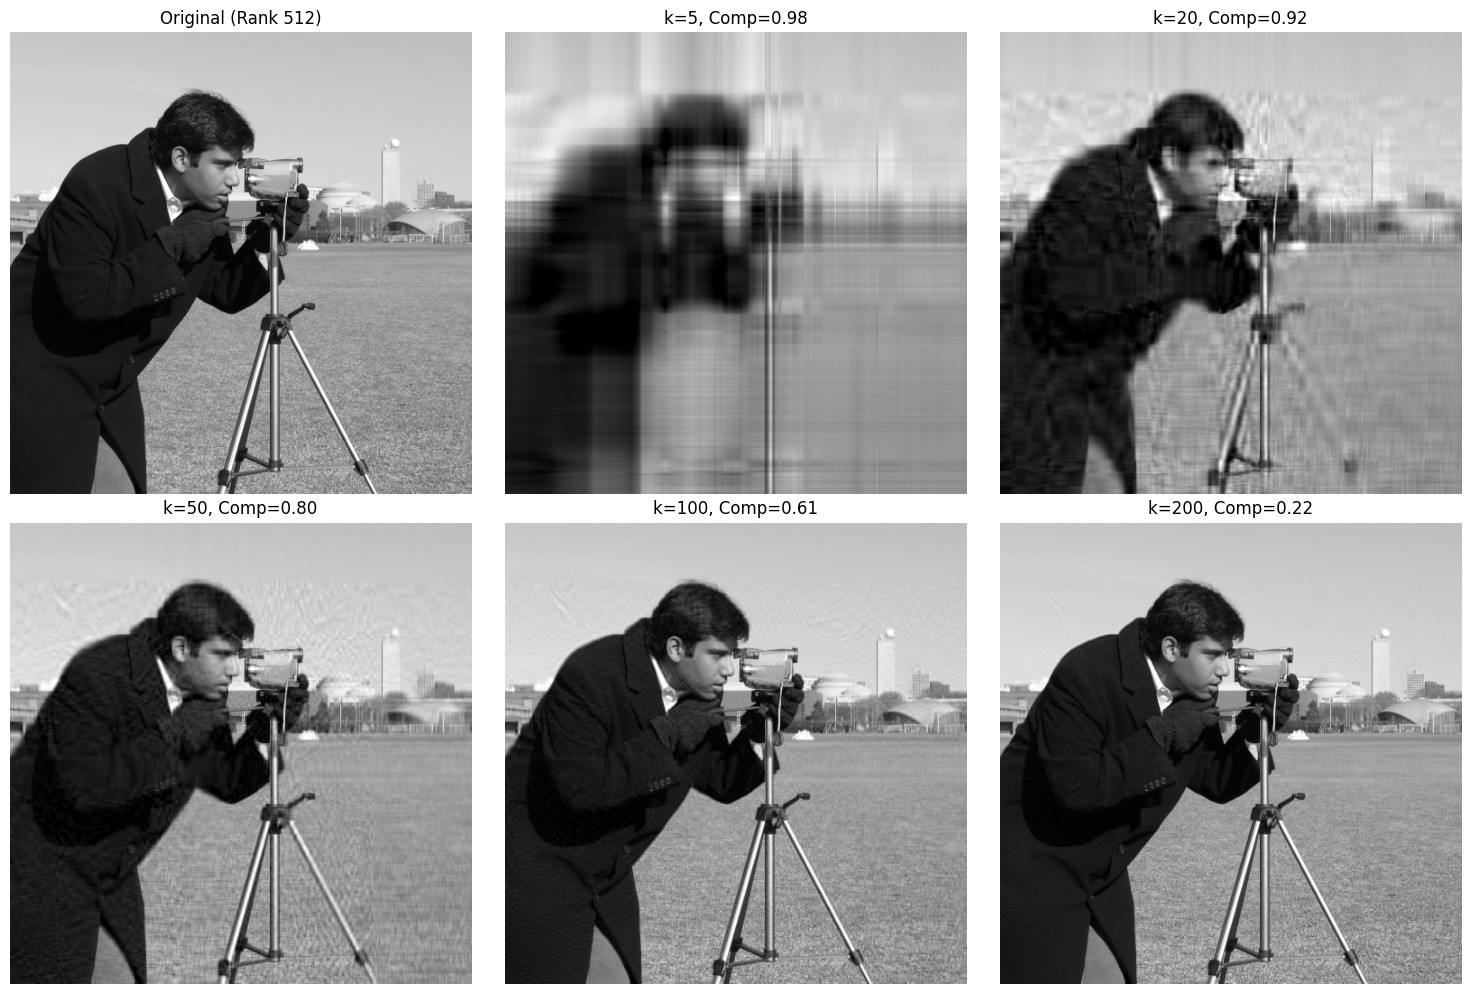

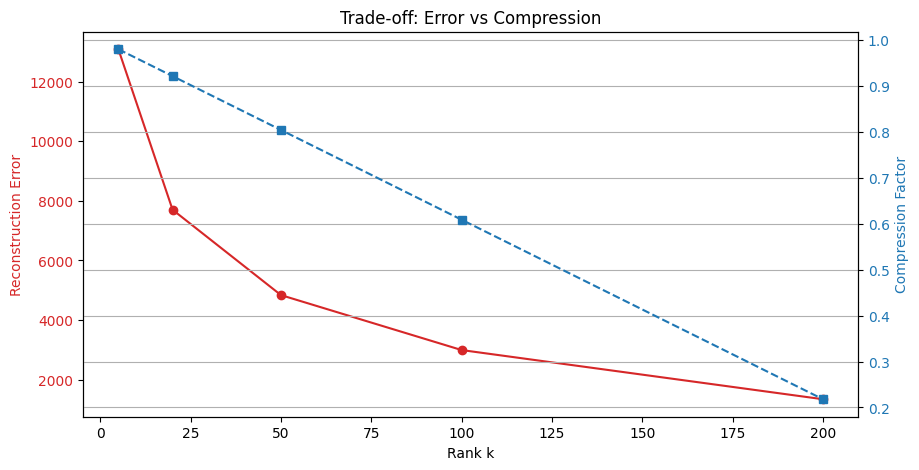

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data

# 1. Load the image
X = skimage.data.camera()
m, n = X.shape
print(f"Image shape: {X.shape}")

# 2. Compute its SVD
# For image compression, X must be float for proper processing
X_float = X.astype(float)
U, s, Vt = np.linalg.svd(X_float, full_matrices=False)
# full_matrices=False is faster and sufficient (returns U as m x min(m,n))

# 3. Loop over k values
k_values = [5, 20, 50, 100, 200]
reconstructed_images = []
errors = []
compression_factors = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot original
axes[0].imshow(X, cmap="gray")
axes[0].set_title(f"Original (Rank {min(m,n)})")
axes[0].axis("off")

for i, k in enumerate(k_values):
    # Compute Rank-k approximation
    # X_k = U[:, :k] * S[:k] * Vt[:k, :]
    X_k = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

    # Clip values to valid image range [0, 255]
    X_k_clipped = np.clip(X_k, 0, 255)

    # Compute compression factor
    # size of U_k (m*k) + s_k (k) + V_k (k*n) vs original (m*n)
    # Formula given: c_k = 1 - k(m+n+1)/mn
    c_k = 1 - (k * (m + n + 1)) / (m * n)
    compression_factors.append(c_k)

    # Compute reconstruction error
    error = np.linalg.norm(X_float - X_k, ord="fro")
    errors.append(error)

    # Plot
    ax = axes[i + 1]
    ax.imshow(X_k_clipped, cmap="gray")
    ax.set_title(f"k={k}, Comp={c_k:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Plot Error and Compression Factor
fig, ax1 = plt.subplots(figsize=(10, 5))

color = "tab:red"
ax1.set_xlabel("Rank k")
ax1.set_ylabel("Reconstruction Error", color=color)
ax1.plot(k_values, errors, "o-", color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = "tab:blue"
ax2.set_ylabel("Compression Factor", color=color)
ax2.plot(k_values, compression_factors, "s--", color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Trade-off: Error vs Compression")
plt.grid(True)
plt.show()

- **Visual Quality:** At very low $k$ (e.g., 5), the image is blurry and only outlines are visible. As $k$ increases to 50 or 100, the image becomes nearly indistinguishable from the original to the human eye, even though we dropped hundreds of dimensions.

- **Energy:** Most of the "energy" (information) is concentrated in the first few singular values. The singular values decay rapidly for natural images.
- **Trade-off:** High compression (low $k$) yields high error and low fidelity. Low compression (high $k$) yields low error but saves less space.

# Exercise 4: PCA + Clustering on a Real Dataset
This exercises uses SVD to perform PCA (Principal Component Analysis) manually. 
>> NOTE: You must have the `train.csv` file from the Kaggle MNIST dataset in your working directory. 


Dataset loaded successfully.
Train shape: (6738, 784), Test shape: (1685, 784)


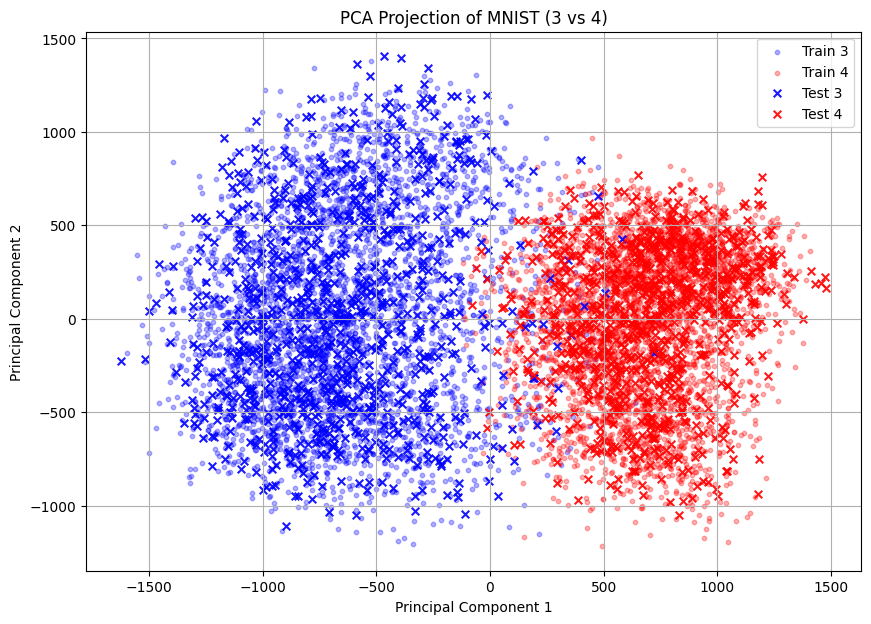

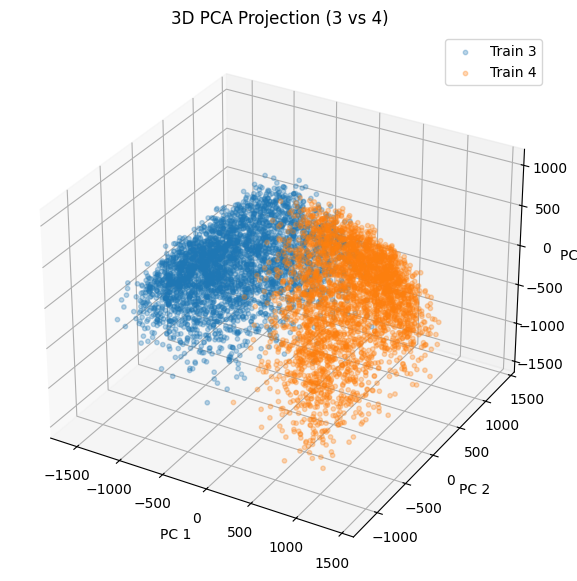

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the CSV file
# Ensure 'train.csv' is in the same directory or provide the correct path
try:
    df = pd.read_csv("train.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'train.csv' not found. Please download it from Kaggle.")
    # Stop execution if file not found for the sake of the example
    df = pd.DataFrame(columns=["label"] + [f"pixel{i}" for i in range(784)])

# 2. Filter only digits 3 and 4
subset = df[df["label"].isin([3, 4])]
X_full = subset.drop("label", axis=1).values
y_full = subset["label"].values

# Split into training and test sets (80% train, 20% test manually)
num_samples = X_full.shape[0]
split_idx = int(num_samples * 0.8)

# Shuffle first to ensure random distribution
indices = np.arange(num_samples)
np.random.shuffle(indices)

X_train = X_full[indices[:split_idx]]
y_train = y_full[indices[:split_idx]]
X_test = X_full[indices[split_idx:]]
y_test = y_full[indices[split_idx:]]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 3. Center the training data
mean_vector = np.mean(X_train, axis=0)
X_c_train = X_train - mean_vector

# 4. Compute the reduced SVD of the centered training data
# We only need the top k=2 components, usually svd returns all,
# but for visualization we take the first few rows of Vt
U, s, Vt = np.linalg.svd(X_c_train, full_matrices=False)

# 5. Choose k=2 principal components
k = 2
V_2 = Vt[:k, :].T  # Transpose to get shape (d, k) = (784, 2)

# 6. Project
Z_train = X_c_train @ V_2

# For test set, center using TRAINING mean, then project
X_c_test = X_test - mean_vector
Z_test = X_c_test @ V_2

# 7. Plot Scatterplots
plt.figure(figsize=(10, 7))

# Plot Train
colors = {3: "blue", 4: "red"}
for label in [3, 4]:
    idx = y_train == label
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=f"Train {label}", alpha=0.3, c=colors[label], s=10)

# Plot Test (Overlay)
for label in [3, 4]:
    idx = y_test == label
    plt.scatter(Z_test[idx, 0], Z_test[idx, 1], label=f"Test {label}", alpha=0.9, marker="x", c=colors[label], s=30)

plt.title("PCA Projection of MNIST (3 vs 4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# 8. Discussion (Concept):
# If you repeat with 1 vs 7 (very distinct vertical shapes) separation is usually clear.
# If you repeat with 5 vs 8 (curved shapes), overlap might be higher in 2D.

# 9. Try k=3 and 3D scatterplot
k_3 = 3
V_3 = Vt[:k_3, :].T
Z_train_3d = X_c_train @ V_3

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

for label in [3, 4]:
    idx = y_train == label
    ax.scatter(Z_train_3d[idx, 0], Z_train_3d[idx, 1], Z_train_3d[idx, 2], label=f"Train {label}", alpha=0.3, s=10)

ax.set_title("3D PCA Projection (3 vs 4)")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.legend()
plt.show()

# Exercise 5: Classification After PCA: Linear Classifier and Centroid Classifier
This connects unsupervised dimensionality reduction with supervised classification.

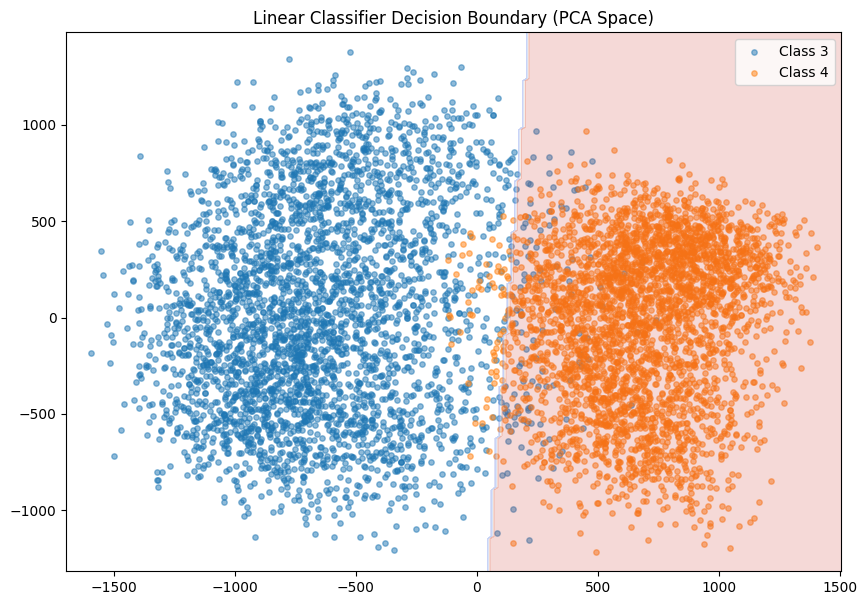

--- Linear Classifier Results ---
Accuracy: 0.9768545994065282

Classification Report:
               precision    recall  f1-score   support

           3       0.98      0.98      0.98       870
           4       0.97      0.98      0.98       815

    accuracy                           0.98      1685
   macro avg       0.98      0.98      0.98      1685
weighted avg       0.98      0.98      0.98      1685

Confusion Matrix:
 [[849  21]
 [ 18 797]]

Centroid 3: [-639.57599946   30.09534871]
Centroid 4: [683.56280446 -32.1651547 ]


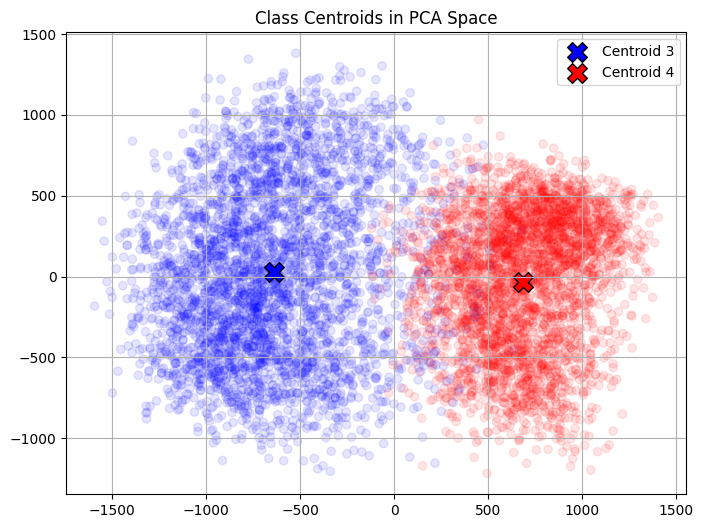

--- Centroid Classifier Results ---
Accuracy: 0.9774480712166173

Classification Report:
               precision    recall  f1-score   support

           3       0.99      0.96      0.98       870
           4       0.96      0.99      0.98       815

    accuracy                           0.98      1685
   macro avg       0.98      0.98      0.98      1685
weighted avg       0.98      0.98      0.98      1685



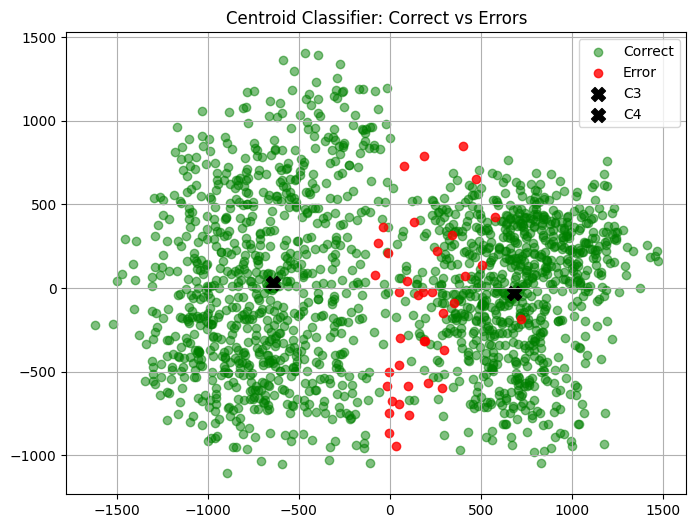

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Step 1: PCA Projection (Already done in Ex 5, ensuring variables exist) ---
# We use Z_train, Z_test, y_train, y_test, V_2 from Exercise 5

# --- Step 2: Fit a linear classifier (Logistic Regression) ---

# 1. Train Logistic Regression on the 2D PCA features
# Note: Z_train has shape (N, 2)
log_reg = LogisticRegression()
log_reg.fit(Z_train, y_train)

# 2. Plotting Decision Boundary
plt.figure(figsize=(10, 7))

# Scatter plot of training data
for label in [3, 4]:
    idx = y_train == label
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=f"Class {label}", alpha=0.5, s=15)

# Create meshgrid for boundary
x_min, x_max = Z_train[:, 0].min() - 100, Z_train[:, 0].max() + 100
y_min, y_max = Z_train[:, 1].min() - 100, Z_train[:, 1].max() + 100
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict on meshgrid
Z_mesh = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z_mesh = Z_mesh.reshape(xx.shape)

plt.contourf(xx, yy, Z_mesh, alpha=0.2, cmap=plt.cm.coolwarm)
plt.title("Linear Classifier Decision Boundary (PCA Space)")
plt.legend()
plt.show()

# 3. Compute metrics on Test set
y_pred_linear = log_reg.predict(Z_test)
print("--- Linear Classifier Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_linear))
print("\nClassification Report:\n", classification_report(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))


# --- Step 3: PCA-Centroid Classifier ---

# 1. Compute centroids in PCA space
# Z_train contains the projected points
centroid_3 = np.mean(Z_train[y_train == 3], axis=0)
centroid_4 = np.mean(Z_train[y_train == 4], axis=0)

print(f"\nCentroid 3: {centroid_3}")
print(f"Centroid 4: {centroid_4}")

# Plot centroids
plt.figure(figsize=(8, 6))
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, alpha=0.1, cmap="bwr")
plt.scatter(centroid_3[0], centroid_3[1], c="blue", s=200, marker="X", label="Centroid 3", edgecolors="black")
plt.scatter(centroid_4[0], centroid_4[1], c="red", s=200, marker="X", label="Centroid 4", edgecolors="black")
plt.legend()
plt.title("Class Centroids in PCA Space")
plt.grid(True)
plt.show()


# 2. Classification logic: nearest centroid
def centroid_predict(X_projected, c3, c4):
    preds = []
    for point in X_projected:
        dist3 = np.linalg.norm(point - c3)
        dist4 = np.linalg.norm(point - c4)
        if dist3 < dist4:
            preds.append(3)
        else:
            preds.append(4)
    return np.array(preds)


y_pred_centroid = centroid_predict(Z_test, centroid_3, centroid_4)

# 3. Metrics for Centroid Classifier
print("--- Centroid Classifier Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_centroid))
print("\nClassification Report:\n", classification_report(y_test, y_pred_centroid))

# Plot Test points colored by classification result
plt.figure(figsize=(8, 6))
# Correct classifications
correct_idx = y_test == y_pred_centroid
plt.scatter(Z_test[correct_idx, 0], Z_test[correct_idx, 1], c="green", alpha=0.5, label="Correct")
# Misclassified
plt.scatter(Z_test[~correct_idx, 0], Z_test[~correct_idx, 1], c="red", alpha=0.8, label="Error")
plt.scatter(centroid_3[0], centroid_3[1], c="black", s=100, marker="X", label="C3")
plt.scatter(centroid_4[0], centroid_4[1], c="black", s=100, marker="X", label="C4")
plt.title("Centroid Classifier: Correct vs Errors")
plt.legend()
plt.grid(True)
plt.show()

**Comparison:** Usually, the Logistic Regression (Linear Classifier) performs slightly better or similarly to the Centroid classifier if the clusters are roughly spherical (isotropic) and linearly separable. The Centroid classifier is essentially a geometric classifier that works best when classes have similar variance and are well-separated in Euclidean space.

**Centroids vs Linear Boundary:** The decision boundary for the Nearest Centroid classifier is the perpendicular bisector of the line segment connecting the two centroids. Logistic regression finds the boundary that minimizes the cross-entropy loss, which might differ slightly, especially if the data density is not balanced or the variance differs between classes.